In [2]:
# Differential Privacy Neural Network Training with Hyperparameter Tuning and EarlyStopping Toggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
import os

os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Load data
data = pd.read_csv('C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-processed.csv')
X = data.drop(columns=['y'])
y = data['y']

# Normalize numeric columns
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
X[numeric_cols] = MinMaxScaler().fit_transform(X[numeric_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTEENN
X_resample, y_resample = SMOTEENN(random_state=42).fit_resample(X_train, y_train)
X_resample = pd.DataFrame(X_resample, columns=X.columns)
y_resample = pd.Series(y_resample)

# Boruta feature selection
rf = xgb.XGBClassifier(eval_metric='logloss')
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
feat_selector.fit(X_resample.values, y_resample.values.ravel())
X_filtered = X.columns[feat_selector.support_].tolist()

X_train_filtered = X_resample[X_filtered].values
X_test_filtered = X_test[X_filtered].values
y_train_filtered = y_resample.values
y_test_filtered = y_test.values

# Training parameters
input_size = len(X_filtered)
hidden_units = 64
hidden_layers = 2
dropout_rate = 0.2
epochs = 50
learning_rate = 0.001
l2_norm_clip = 1.0
default_noise_multiplier = 1.1

# DP parameters
def compute_privacy_budget(n, batch_size, noise_multiplier, epochs, delta=1e-5):
    try:
        return compute_dp_sgd_privacy.compute_dp_sgd_privacy(
            n=n, batch_size=batch_size, noise_multiplier=noise_multiplier, epochs=epochs, delta=delta)[0]
    except:
        return float('inf')

def create_model(input_size, hidden_units, hidden_layers, dropout_rate, learning_rate, num_microbatches, l2_norm_clip, noise_multiplier, use_dp):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(input_size,)))
    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    if use_dp:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate
        )
    else:
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(X_train, y_train, X_test, y_test, batch_size, epochs, learning_rate, use_dp, noise_multiplier, l2_norm_clip, use_early_stopping):
    num_microbatches = batch_size
    model = create_model(
        input_size, hidden_units, hidden_layers, dropout_rate,
        learning_rate, num_microbatches, l2_norm_clip,
        noise_multiplier, use_dp
    )

    callbacks = []
    if use_early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

    model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test),
        callbacks=callbacks
    )

    y_pred_prob = model.predict(X_test, batch_size=batch_size).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    return y_pred_prob, y_pred

def evaluate_model(y_true, y_pred, y_pred_prob):
    cm = confusion_matrix(y_true, y_pred)
    return {
        'ROC AUC': roc_auc_score(y_true, y_pred_prob),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Type I Error': cm[0][1] / cm[0].sum() if cm[0].sum() > 0 else 0,
        'Type II Error': cm[1][0] / cm[1].sum() if cm[1].sum() > 0 else 0
    }

def run_experiment(batch_size, learning_rate, noise_multiplier, l2_norm_clip, use_dp=True, use_early_stopping=True):
    eps = compute_privacy_budget(len(X_train_filtered), batch_size, noise_multiplier, epochs)
    print(f"Running: batch_size={batch_size}, lr={learning_rate}, noise={noise_multiplier}, clip={l2_norm_clip}, eps={eps:.2f}")
    y_prob, y_pred = train_model(
        X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered,
        batch_size=batch_size, epochs=epochs, learning_rate=learning_rate,
        use_dp=use_dp, noise_multiplier=noise_multiplier, l2_norm_clip=l2_norm_clip,
        use_early_stopping=use_early_stopping
    )
    results = evaluate_model(y_test_filtered, y_pred, y_prob)
    results['Epsilon'] = eps
    results['Batch Size'] = batch_size
    results['Noise Multiplier'] = noise_multiplier
    results['Learning Rate'] = learning_rate
    results['Clipping Norm'] = l2_norm_clip
    return results

# Automated experiment loop
def grid_search_experiments():
    batch_sizes = [16, 32, 64, 128]
    noise_multipliers = [0.8, 1.1, 1.5, 2.0]
    learning_rates = [0.001, 0.003, 0.005]  # Larger batch size → larger LR
    clip_norms = [0.5, 1.0, 2.0]  # Higher batch sizes might allow more signal

    results = []
    for batch_size in batch_sizes:
        for noise in noise_multipliers:
            for lr in learning_rates:
                for clip in clip_norms:
                    res = run_experiment(
                        batch_size=batch_size,
                        learning_rate=lr,
                        noise_multiplier=noise,
                        l2_norm_clip=clip,
                        use_dp=True,
                        use_early_stopping=True
                    )
                    results.append(res)
    return pd.DataFrame(results)



c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [ ]:
# Run grid search
df_results = grid_search_experiments()
df_results.round(3).to_csv('results/cdp_grid_search.csv', index=False)
print(df_results.sort_values('ROC AUC', ascending=False).head())


DP-SGD with sampling rate = 0.0299% and noise_multiplier = 0.8 iterated over 167200 steps satisfies differential privacy with eps = 1.7 and delta = 1e-05.
The optimal RDP order is 9.0.
Running: batch_size=16, lr=0.001, noise=0.8, clip=0.5, eps=1.70
Epoch 1/50
3344/3344 [==============================] - 2s 614us/step - loss: 0.6534 - accuracy: 0.6097 - val_loss: 0.6563 - val_accuracy: 0.6355
Epoch 2/50
3344/3344 [==============================] - 2s 587us/step - loss: 0.6068 - accuracy: 0.6711 - val_loss: 0.6090 - val_accuracy: 0.6800
Epoch 3/50
3344/3344 [==============================] - 2s 555us/step - loss: 0.5782 - accuracy: 0.7015 - val_loss: 0.6752 - val_accuracy: 0.5962
Epoch 4/50
3344/3344 [==============================] - 2s 551us/step - loss: 0.5595 - accuracy: 0.7151 - val_loss: 0.5748 - val_accuracy: 0.6910
Epoch 5/50
3344/3344 [==============================] - 2s 556us/step - loss: 0.5426 - accuracy: 0.7239 - val_loss: 0.5901 - val_accuracy: 0.6739
Epoch 6/50
3344/3344 

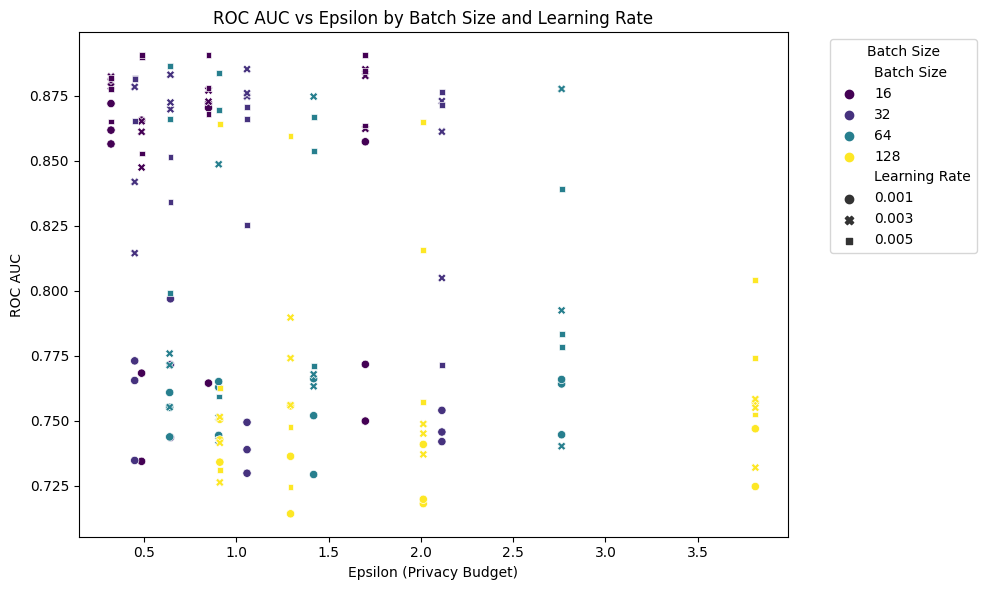

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load your results
df = df_results.copy()

# Visualization 1: 2D scatter of Epsilon vs ROC AUC, colored by Batch Size
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Epsilon', y='ROC AUC', hue='Batch Size', palette='viridis', style='Learning Rate')
plt.title('ROC AUC vs Epsilon by Batch Size and Learning Rate')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('ROC AUC')
plt.legend(title='Batch Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


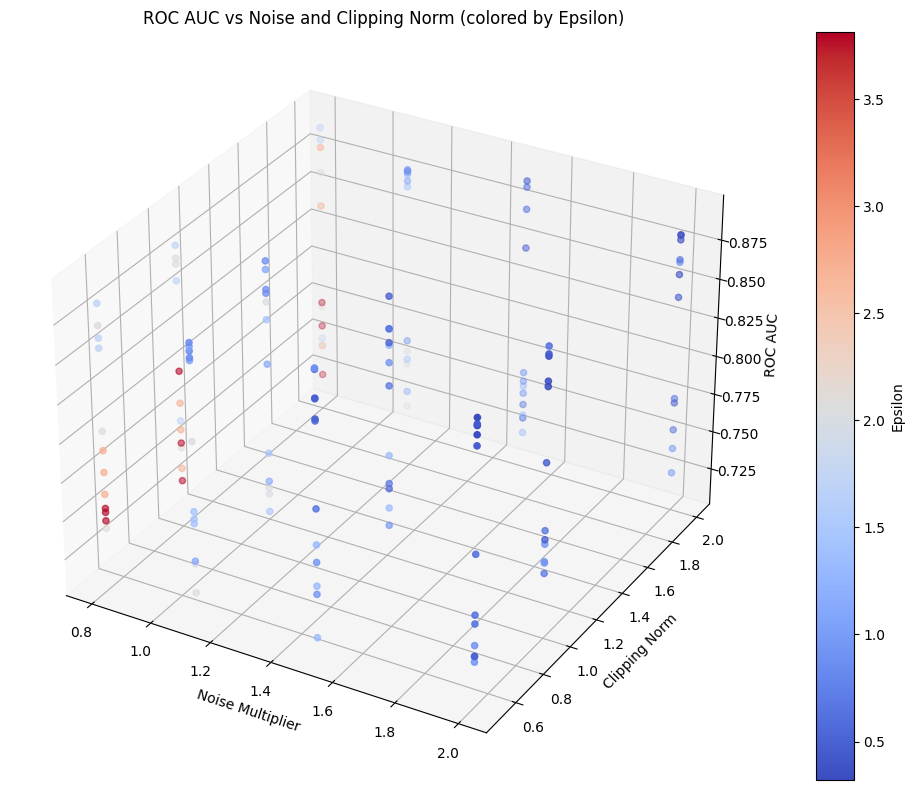

In [11]:

# Visualization 2: 3D plot of Noise Multiplier vs Clipping Norm vs ROC AUC
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['Noise Multiplier'], df['Clipping Norm'], df['ROC AUC'], c=df['Epsilon'], cmap='coolwarm')
ax.set_title('ROC AUC vs Noise and Clipping Norm (colored by Epsilon)')
ax.set_xlabel('Noise Multiplier')
ax.set_ylabel('Clipping Norm')
ax.set_zlabel('ROC AUC')
fig.colorbar(scatter, label='Epsilon')
plt.tight_layout()
plt.show()

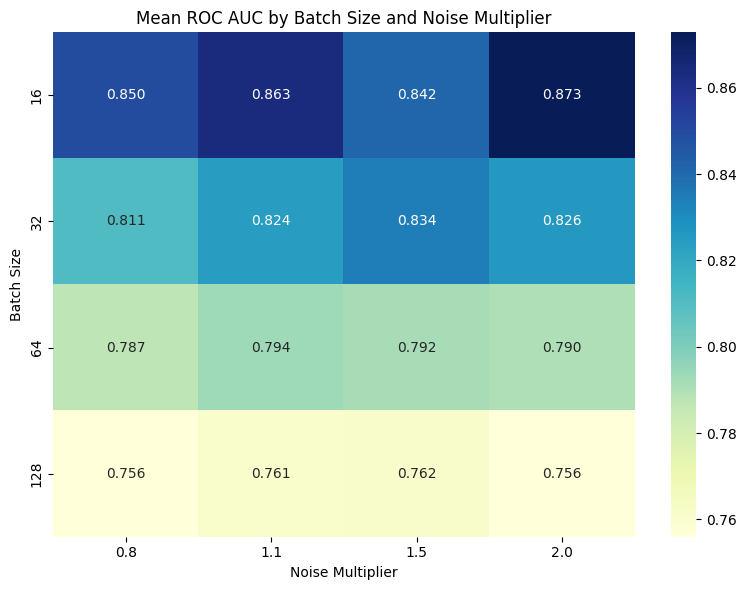

In [12]:
# Visualization 3: Heatmap of mean ROC AUC by Batch Size and Noise Multiplier
pivot_heatmap = df.pivot_table(values='ROC AUC', index='Batch Size', columns='Noise Multiplier', aggfunc='mean')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_heatmap, annot=True, fmt=".3f", cmap='YlGnBu')
plt.title('Mean ROC AUC by Batch Size and Noise Multiplier')
plt.tight_layout()
plt.show()


In [13]:



# Visualization 4: ROC AUC per unit of Epsilon (utility/ε ratio)
df['Utility per Epsilon'] = df['ROC AUC'] / df['Epsilon']
top_utility = df.sort_values('Utility per Epsilon', ascending=False).head(10)
top_utility[['ROC AUC', 'Epsilon', 'Utility per Epsilon', 'Config']]


,ROC AUC,Epsilon,Utility per Epsilon,Config
30,0.882346,0.320231,2.755341,"BS=16.0, Noise=2.0, LR=0.003, Clip=0.5"
35,0.881776,0.320231,2.753560,"BS=16.0, Noise=2.0, LR=0.005, Clip=2.0"
31,0.880369,0.320231,2.749166,"BS=16.0, Noise=2.0, LR=0.003, Clip=1.0"
32,0.878521,0.320231,2.743396,"BS=16.0, Noise=2.0, LR=0.003, Clip=2.0"
33,0.877526,0.320231,2.740290,"BS=16.0, Noise=2.0, LR=0.005, Clip=0.5"
27,0.871992,0.320231,2.723007,"BS=16.0, Noise=2.0, LR=0.001, Clip=0.5"
34,0.865063,0.320231,2.701371,"BS=16.0, Noise=2.0, LR=0.005, Clip=1.0"
28,0.861759,0.320231,2.691052,"BS=16.0, Noise=2.0, LR=0.001, Clip=1.0"
29,0.856435,0.320231,2.674428,"BS=16.0, Noise=2.0, LR=0.001, Clip=2.0"
70,0.881724,0.448645,1.965305,"BS=32.0, Noise=2.0, LR=0.005, Clip=1.0"
